# Modelo con sklearn

In [91]:
# -----------------------------
# Manipulación de datos
# -----------------------------
import pandas as pd
import numpy as np
import time

# -----------------------------
# Visualización
# -----------------------------
import matplotlib.pyplot as plt

# -----------------------------
# Preprocesamiento y transformaciones
# -----------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# -----------------------------
# División de datos y búsqueda de hiperparámetros
# -----------------------------
from sklearn.model_selection import train_test_split, GridSearchCV

# -----------------------------
# Modelos
# -----------------------------
from sklearn.neural_network import MLPClassifier

# -----------------------------
# Métricas
# -----------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
)

# -----------------------------
# Balanceo de clases
# -----------------------------
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # pipeline que permite SMOTE


import torch
import torch.nn as nn
import torch.optim as optim
import torch_directml

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Cargar el dataset
file = r"C:\Users\Hp\MACHINE\MINI_PRY_1\data\data_lend.csv"
df = pd.read_csv(file, low_memory=False)

# EL dataset

In [4]:
df.drop(columns =['total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                  'recoveries', 'last_pymnt_amnt', 'last_fico_range_mean',
                  'payment_effiency', 'has_payment_plan', 'had_hardship',
                  'tax_liens', 'all_util', 'open_rv_12m', 'open_act_il', 'max_bal_bc', 'total_bal_il', 'out_prncp',
                  'acc_open_past_24mths'
                  ], inplace=True)

In [5]:
variable_dict = {
    "prestamo": {
        "funded_amnt": "monto_aprobado",
        "int_rate": "tasa_interes",
        "installment": "cuota_mensual",
        "term_num": "plazo_meses",
        "purpose": "motivo_prestamo",
        "disbursement_method_num": "metodo_desembolso",
        "initial_list_status_num": "estado_inicial_listado",
        "application_type_num": "tipo_aplicacion",
        "loan_gap": "dif_monto_solicitado"
    },
    "prestatario": {
        "annual_inc": "ingreso_anual",
        "home_ownership": "tipo_vivienda",
        "emp_length_num": "antiguedad_laboral",
        "verification_status_num": "estado_verif_ingreso"
    },
    "historial_crediticio": {
        "fico_range_mean": "promedio_fico",
        "earliest_cr_line_year": "año_apertura_credito",
        "earliest_cr_line_month": "mes_apertura_credito",
        "mort_acc": "cuentas_hipotecarias",
        "total_acc": "total_cuentas_credito",
        "num_sats": "cuentas_abiertas",
        "num_bc_sats": "cuentas_tarjeta_credito",
        "revol_bal": "saldo_revolvente",
        "revol_util": "uso_credito_revolvente",
        "bc_util": "uso_tarjetas_credito",
        "tot_hi_cred_lim": "limite_credito_total"
    },
    "comportamiento_prestatario": {
        "mths_since_recent_inq": "meses_ultima_consulta",
        "mths_since_recent_bc": "meses_tarjeta_nueva",
        "mths_since_recent_revol_delinq": "meses_mora_revolvente",
        "num_tl_op_past_12m": "lineas_credito_12m",
        "pct_tl_nvr_dlq": "porcentaje_sin_moras"
    },
    "morosidad_riesgo": {
        "delinq_2yrs": "moras_2_year",
        "mths_since_last_delinq": "meses_ultima_mora",
        "delinq_amnt": "monto_mora",
        "num_tl_90g_dpd_24m": "lineas_90_dias_mora_24m",
        "num_tl_120dpd_2m": "lineas_120_dias_mora_2m",
        "chargeoff_within_12_mths": "castigos_12m",
        "collections_12_mths_ex_med": "cobranzas_12m",
        "acc_now_delinq": "cuentas_en_mora_actual",
        "tot_coll_amt": "monto_total_cobranzas",
        "pub_rec_bankruptcies": "quiebras_publicas",
        "had_settlement": "tuvo_acuerdo_pago"
    },
    "tecnicas_control": {
        "grade": "categoria_credito",
        "sub_grade_num": "subcategoria_credito",
        "issue_d_year": "año_emision_prestamo",
        "issue_d_month": "mes_emision_prestamo"
    }
}
# Combinar todos los subdiccionarios en uno solo
rename_map = {k: v for group in variable_dict.values() for k, v in group.items()}

# Renombrar columnas
df.rename(columns=rename_map, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 46 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   monto_aprobado           1345310 non-null  float64
 1   tasa_interes             1345310 non-null  float64
 2   cuota_mensual            1345310 non-null  float64
 3   categoria_credito        1345310 non-null  object 
 4   tipo_vivienda            1345310 non-null  object 
 5   ingreso_anual            1345310 non-null  float64
 6   motivo_prestamo          1345310 non-null  object 
 7   dti                      1344401 non-null  float64
 8   moras_2_year             1345310 non-null  float64
 9   meses_ultima_mora        1345310 non-null  float64
 10  saldo_revolvente         1345310 non-null  float64
 11  uso_credito_revolvente   1344453 non-null  float64
 12  total_cuentas_credito    1345310 non-null  float64
 13  cobranzas_12m            1345254 non-null 

In [6]:
# Listas según estrategia
imputar_cero = [
    "lineas_120_dias_mora_2m",
    "lineas_90_dias_mora_24m",
    "monto_total_cobranzas",
    "quiebras_publicas",
    "cobranzas_12m",
    "castigos_12m",
    "cuentas_tarjeta_credito",
    "cuentas_abiertas",
    "cuentas_hipotecarias"
]

imputar_mediana = [
    "porcentaje_sin_moras",
    "limite_credito_total",
    "lineas_credito_12m",
    "uso_tarjetas_credito",
    "dti",
    "uso_credito_revolvente"
]
for col in imputar_cero:
    if col in df.columns:
        df[col] = df[col].fillna(0)

for col in imputar_mediana:
    if col in df.columns:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

missing_summary = df[imputar_cero + imputar_mediana].isnull().sum()
print(missing_summary[missing_summary > 0])

Series([], dtype: int64)


In [ ]:
# VIF

# 1️⃣ Selecciona solo variables numéricas (excluyendo la variable objetivo 'default')
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('default')  # excluimos la variable objetivo

# 2️⃣ Opcional: si tienes variables altamente correlacionadas entre sí, puedes eliminar algunas para no inflar el VIF
num_cols.remove('cuota_mensual')
num_cols.remove('uso_tarjetas_credito')
num_cols.remove('meses_ultima_mora')

# 3️⃣ Prepara la matriz con constante
X = add_constant(df[num_cols])

# 4️⃣ Calcula VIF para cada variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 5️⃣ Ordena por VIF descendente
print(vif_data[vif_data['VIF'] > 2].sort_values(by='VIF', ascending=False))

                   Variable           VIF
0                     const  2.255739e+06
19         cuentas_abiertas  3.154659e+00
8     total_cuentas_credito  2.337871e+00
5              moras_2_year  2.192850e+00
32            promedio_fico  2.107317e+00
25     limite_credito_total  2.033952e+00
18  cuentas_tarjeta_credito  2.031506e+00


### Variables seleccionadas

In [7]:
df.drop(columns=['cuota_mensual', 'uso_tarjetas_credito', 'meses_ultima_mora', 'cuentas_abiertas'], inplace=True)
df.columns

Index(['monto_aprobado', 'tasa_interes', 'categoria_credito', 'tipo_vivienda',
       'ingreso_anual', 'motivo_prestamo', 'dti', 'moras_2_year',
       'saldo_revolvente', 'uso_credito_revolvente', 'total_cuentas_credito',
       'cobranzas_12m', 'cuentas_en_mora_actual', 'monto_total_cobranzas',
       'castigos_12m', 'monto_mora', 'cuentas_hipotecarias',
       'meses_tarjeta_nueva', 'meses_ultima_consulta', 'meses_mora_revolvente',
       'cuentas_tarjeta_credito', 'lineas_120_dias_mora_2m',
       'lineas_90_dias_mora_24m', 'lineas_credito_12m', 'porcentaje_sin_moras',
       'quiebras_publicas', 'limite_credito_total', 'default',
       'tuvo_acuerdo_pago', 'plazo_meses', 'estado_inicial_listado',
       'tipo_aplicacion', 'metodo_desembolso', 'estado_verif_ingreso',
       'promedio_fico', 'subcategoria_credito', 'año_emision_prestamo',
       'año_apertura_credito', 'mes_emision_prestamo', 'mes_apertura_credito',
       'antiguedad_laboral', 'dif_monto_solicitado'],
      dtype=

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 42 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   monto_aprobado           1345310 non-null  float64
 1   tasa_interes             1345310 non-null  float64
 2   categoria_credito        1345310 non-null  object 
 3   tipo_vivienda            1345310 non-null  object 
 4   ingreso_anual            1345310 non-null  float64
 5   motivo_prestamo          1345310 non-null  object 
 6   dti                      1345310 non-null  float64
 7   moras_2_year             1345310 non-null  float64
 8   saldo_revolvente         1345310 non-null  float64
 9   uso_credito_revolvente   1345310 non-null  float64
 10  total_cuentas_credito    1345310 non-null  float64
 11  cobranzas_12m            1345310 non-null  float64
 12  cuentas_en_mora_actual   1345310 non-null  float64
 13  monto_total_cobranzas    1345310 non-null 

### RANDOM FOREST

In [ ]:
X = df.drop('default', axis=1)
y = df['default']

In [40]:
# 2️⃣ Identificar variables
num_cols = X.select_dtypes(include=['float64','int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [ ]:
# 4️⃣ Codificación de categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

In [49]:
# 6️⃣ Entrenar Random Forest
rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

# 7️⃣ Importancia de variables
importances = rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
print(feat_imp.head(20))  # Top 20 variables

                            feature  importance
51     remainder__tuvo_acuerdo_pago    0.440056
28          remainder__tasa_interes    0.149035
52           remainder__plazo_meses    0.075418
0          cat__categoria_credito_A    0.057560
1          cat__categoria_credito_B    0.031988
4          cat__categoria_credito_E    0.027758
57         remainder__promedio_fico    0.025719
30                   remainder__dti    0.019550
3          cat__categoria_credito_D    0.018295
59  remainder__año_emision_prestamo    0.015820
2          cat__categoria_credito_C    0.015037
5          cat__categoria_credito_F    0.014850
50  remainder__limite_credito_total    0.013652
27        remainder__monto_aprobado    0.013245
40  remainder__cuentas_hipotecarias    0.008863
8       cat__tipo_vivienda_MORTGAGE    0.007645
56  remainder__estado_verif_ingreso    0.007010
12          cat__tipo_vivienda_RENT    0.006780
29         remainder__ingreso_anual    0.006686
47    remainder__lineas_credito_12m    0

In [61]:
print(feat_imp.tail(50))

                                    feature  importance
8               cat__tipo_vivienda_MORTGAGE    0.007645
56          remainder__estado_verif_ingreso    0.007010
12                  cat__tipo_vivienda_RENT    0.006780
29                 remainder__ingreso_anual    0.006686
47            remainder__lineas_credito_12m    0.006216
63            remainder__antiguedad_laboral    0.004810
6                  cat__categoria_credito_G    0.004054
41           remainder__meses_tarjeta_nueva    0.003257
33        remainder__uso_credito_revolvente    0.002940
32              remainder__saldo_revolvente    0.002902
58          remainder__subcategoria_credito    0.002779
60          remainder__año_apertura_credito    0.002664
42         remainder__meses_ultima_consulta    0.001957
44       remainder__cuentas_tarjeta_credito    0.001928
34         remainder__total_cuentas_credito    0.001654
53        remainder__estado_inicial_listado    0.001286
48          remainder__porcentaje_sin_moras    0

## Variables para el MLP

In [9]:
importancie = [
    'monto_aprobado', 'tasa_interes', 'estado_inicial_listado',
    'ingreso_anual', 'tipo_vivienda', 'antiguedad_laboral', 'estado_verif_ingreso',
    'promedio_fico', 'año_apertura_credito', 'cuentas_hipotecarias', 'total_cuentas_credito',
    'cuentas_tarjeta_credito', 'saldo_revolvente', 'uso_credito_revolvente', 'limite_credito_total',
    'dti', 'meses_ultima_consulta', 'meses_tarjeta_nueva', 'lineas_credito_12m', 'porcentaje_sin_moras',
    'tuvo_acuerdo_pago', 'categoria_credito', 'subcategoria_credito',
    'año_emision_prestamo', 'mes_emision_prestamo', 'default'
]

df_mlp = df[importancie].copy()
orden_credito = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df_mlp['categoria_credito_ordinal'] = df_mlp['categoria_credito'].map(orden_credito)
df_mlp.drop(columns=['categoria_credito'], inplace=True)
df_mlp.info()

df_mlp[['meses_ultima_consulta', 'antiguedad_laboral', 'meses_tarjeta_nueva']] = \
    df_mlp[['meses_ultima_consulta', 'antiguedad_laboral', 'meses_tarjeta_nueva']].replace(-1, 0)
mediana_saldo = df_mlp['saldo_revolvente'].median()
df_mlp.replace({'saldo_revolvente': {999: mediana_saldo}}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   monto_aprobado             1345310 non-null  float64
 1   tasa_interes               1345310 non-null  float64
 2   estado_inicial_listado     1345310 non-null  int64  
 3   ingreso_anual              1345310 non-null  float64
 4   tipo_vivienda              1345310 non-null  object 
 5   antiguedad_laboral         1345310 non-null  int64  
 6   estado_verif_ingreso       1345310 non-null  int64  
 7   promedio_fico              1345310 non-null  float64
 8   año_apertura_credito       1345310 non-null  int64  
 9   cuentas_hipotecarias       1345310 non-null  float64
 10  total_cuentas_credito      1345310 non-null  float64
 11  cuentas_tarjeta_credito    1345310 non-null  float64
 12  saldo_revolvente           1345310 non-null  float64
 13  uso_credito_

In [72]:
df_mlp.describe(include=object)

,tipo_vivienda
count,1345310
unique,6
top,MORTGAGE
freq,665579


# MLP

__________________

### Tensor

In [61]:
# Reproductividad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [77]:
# PREPROCESS
# Separar X e y
X = df_mlp.drop('default', axis=1)
y = df_mlp['default'].values

# Identificar variables
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)
X_processed = preprocessor.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=SEED
)

smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [78]:
# Convertir a tensores
device = torch_directml.device()

X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)


In [79]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu'):
        super(MLPModel, self).__init__()
        layers = []
        prev_dim = input_dim
        act_fn = nn.ReLU() if activation=='relu' else nn.Tanh()
        
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(act_fn)
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())  # salida para clasificación binaria
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


In [80]:
param_grid = {
    'hidden_layer_sizes': [[10], [50], [100]],
    'alpha': [0.0001, 0.001, 0.01],  # weight decay en Adam
    'max_iter': [100, 200]           # número de epochs
}

In [81]:
best_recall = 0
best_params = {}
input_dim = X_train_tensor.shape[1]

print("Parámetros: \n")
for hidden in param_grid['hidden_layer_sizes']:
    for alpha in param_grid['alpha']:
        for max_iter in param_grid['max_iter']:
            # Modelo
            model = MLPModel(input_dim, hidden).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=alpha)
            criterion = nn.BCELoss()
            
            # Entrenamiento
            start_time = time.time()
            for epoch in range(max_iter):
                optimizer.zero_grad()
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                loss.backward()
                optimizer.step()
            
            # Evaluación en test
            with torch.no_grad():
                y_pred_prob = model(X_test_tensor).cpu().numpy()
                threshold = 0.3  # puedes cambiar a 0.2, 0.4, etc.
                y_pred = (y_pred_prob >= threshold).astype(int)
                recall = recall_score(y_test, y_pred)

            training_time = time.time() - start_time
            
            print(f"Hidden:{hidden}, alpha:{alpha}, epochs:{max_iter}, recall:{recall:.4f}, Tiempo:{training_time:.2f}s")
            
            if recall > best_recall:
                best_recall= recall
                best_params = {'hidden_layer_sizes': hidden, 'alpha': alpha, 'max_iter': max_iter}


Parámetros: 

Hidden:[10], alpha:0.0001, epochs:100, recall:0.9622, Tiempo:25.58s
Hidden:[10], alpha:0.0001, epochs:200, recall:0.9177, Tiempo:48.41s
Hidden:[10], alpha:0.001, epochs:100, recall:0.9978, Tiempo:23.24s
Hidden:[10], alpha:0.001, epochs:200, recall:0.9253, Tiempo:48.39s
Hidden:[10], alpha:0.01, epochs:100, recall:0.9831, Tiempo:24.30s
Hidden:[10], alpha:0.01, epochs:200, recall:0.9235, Tiempo:47.67s
Hidden:[50], alpha:0.0001, epochs:100, recall:0.9209, Tiempo:64.12s
Hidden:[50], alpha:0.0001, epochs:200, recall:0.9098, Tiempo:130.01s
Hidden:[50], alpha:0.001, epochs:100, recall:0.9279, Tiempo:64.00s
Hidden:[50], alpha:0.001, epochs:200, recall:0.9123, Tiempo:128.53s
Hidden:[50], alpha:0.01, epochs:100, recall:0.9416, Tiempo:65.87s
Hidden:[50], alpha:0.01, epochs:200, recall:0.9212, Tiempo:128.28s
Hidden:[100], alpha:0.0001, epochs:100, recall:0.9145, Tiempo:124.05s
Hidden:[100], alpha:0.0001, epochs:200, recall:0.9024, Tiempo:254.05s
Hidden:[100], alpha:0.001, epochs:100, 

-----------------

## skc

In [82]:
# Separar X e y
X = df_mlp.drop('default', axis=1)
y = df_mlp['default']

# Identificar variables
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

In [92]:
# -----------------------------
# 3️⃣ Pipeline con MLP
# -----------------------------
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=SEED)),
    ('mlp', MLPClassifier(
        solver = 'adam',
        activation ='relu',
        max_iter=100,
        random_state=42,
        verbose=True))
])
mlp_pipeline

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [95]:
param_grid_ajusted = {
    'mlp__hidden_layer_sizes': [(10,), (50,)],
    'mlp__alpha': [0.001, 0.01],
}
grid_search = GridSearchCV(
    mlp_pipeline, param_grid_ajusted, 
    cv=3, scoring='recall', verbose=2, n_jobs=-1,
    return_train_score=True)


In [96]:
# -----------------------------
# 6️⃣ Entrenamiento y Evaluación
# -----------------------------
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

best_model = grid_search.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Iteration 1, loss = 0.57728672
Iteration 2, loss = 0.56564533
Iteration 3, loss = 0.56395611
Iteration 4, loss = 0.56256433
Iteration 5, loss = 0.56136633
Iteration 6, loss = 0.55877776
Iteration 7, loss = 0.55610007
Iteration 8, loss = 0.55405078
Iteration 9, loss = 0.55292346
Iteration 10, loss = 0.55167217
Iteration 11, loss = 0.54957118
Iteration 12, loss = 0.54809367
Iteration 13, loss = 0.54721398
Iteration 14, loss = 0.54665698
Iteration 15, loss = 0.54613807
Iteration 16, loss = 0.54571747
Iteration 17, loss = 0.54537775
Iteration 18, loss = 0.54508573
Iteration 19, loss = 0.54487273
Iteration 20, loss = 0.54462382
Iteration 21, loss = 0.54448427
Iteration 22, loss = 0.54429903
Iteration 23, loss = 0.54413585
Iteration 24, loss = 0.54400037
Iteration 25, loss = 0.54392474
Iteration 26, loss = 0.54380556
Iteration 27, loss = 0.54371565
Iteration 28, loss = 0.54357884
Iteration 29, loss = 0.54354117
Iteration 30, loss = 

In [98]:
# Métricas
# AJUSTE DEL UMBRAL DE DECISION
y_pred_adjusted = (y_proba >= 0.3).astype(int)

accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_proba)  # Este no cambia, se basa en probabilidades
cm = confusion_matrix(y_test, y_pred_adjusted)


# Predicción
start_time = time.time()
best_model.predict(X_test)
prediction_time = time.time() - start_time

# Resultados
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
print(f"Tiempo de predicción: {prediction_time:.2f} segundos")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Matriz de Confusión:")
print(cm)

Mejores parámetros: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (10,)}
Tiempo de entrenamiento: 821.69 segundos
Tiempo de predicción: 0.19 segundos
Accuracy: 0.5012
Precision: 0.2685
Recall: 0.8691
F1-Score: 0.4102
ROC AUC: 0.7458
Matriz de Confusión:
[[ 88166 127184]
 [  7033  46679]]


### Ahora si

In [99]:
mlp_sklearn = MLPClassifier(
    alpha=0.01,
    hidden_layer_sizes=(10,),
    max_iter=100,
    solver='adam',
    activation='relu',
    verbose=True,
    random_state=42
)

# Crear pipeline completo
pipeline_sklearn = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=SEED)),
    ('mlp', mlp_sklearn)
])
pipeline_sklearn


,steps,"[('preprocessing', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [100]:
# Entrenamiento
start_time = time.time()
pipeline_sklearn.fit(X_train, y_train)
fit_time = time.time() - start_time

# Predicción
start_time = time.time()
y_pred = pipeline_sklearn.predict(X_test)
y_proba = pipeline_sklearn.predict_proba(X_test)[:, 1]
prediction_time = time.time() - start_time


Iteration 1, loss = 0.57728672
Iteration 2, loss = 0.56564533
Iteration 3, loss = 0.56395611
Iteration 4, loss = 0.56256433
Iteration 5, loss = 0.56136633
Iteration 6, loss = 0.55877776
Iteration 7, loss = 0.55610007
Iteration 8, loss = 0.55405078
Iteration 9, loss = 0.55292346
Iteration 10, loss = 0.55167217
Iteration 11, loss = 0.54957118
Iteration 12, loss = 0.54809367
Iteration 13, loss = 0.54721398
Iteration 14, loss = 0.54665698
Iteration 15, loss = 0.54613807
Iteration 16, loss = 0.54571747
Iteration 17, loss = 0.54537775
Iteration 18, loss = 0.54508573
Iteration 19, loss = 0.54487273
Iteration 20, loss = 0.54462382
Iteration 21, loss = 0.54448427
Iteration 22, loss = 0.54429903
Iteration 23, loss = 0.54413585
Iteration 24, loss = 0.54400037
Iteration 25, loss = 0.54392474
Iteration 26, loss = 0.54380556
Iteration 27, loss = 0.54371565
Iteration 28, loss = 0.54357884
Iteration 29, loss = 0.54354117
Iteration 30, loss = 0.54349057
Iteration 31, loss = 0.54341268
Iteration 32, los


📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9261    0.4094    0.5678    215350
           1     0.2685    0.8691    0.4102     53712

    accuracy                         0.5012    269062
   macro avg     0.5973    0.6392    0.4890    269062
weighted avg     0.7948    0.5012    0.5364    269062



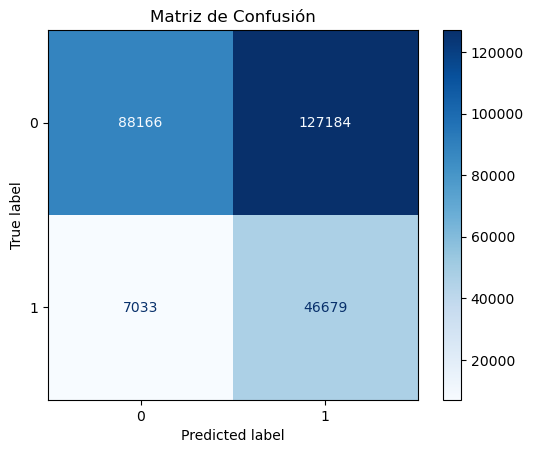

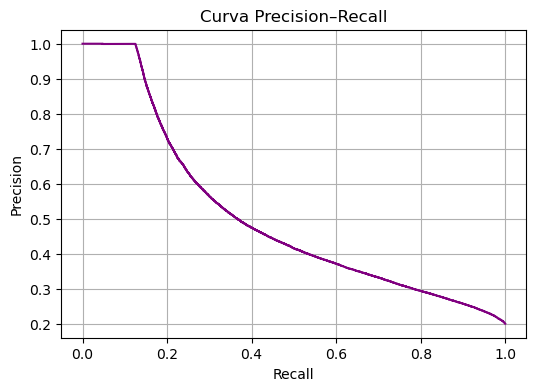

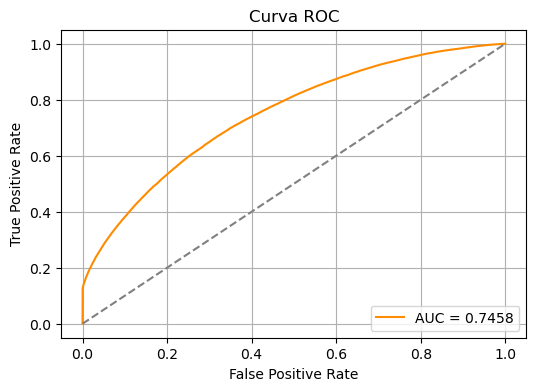

In [101]:
y_pred = (y_proba >= 0.3).astype(int)
# 5. Classification report
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 6. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

# 7. Curva Precision–Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall")
plt.grid(True)
plt.show()

# 8. Curva ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
